In [2]:
!pwd
import netCDF4
import cdsapi

/Users/theoguenais/Desktop/Harvard/Harvard-Classes/hurricast


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from utils import data_processing
from utils import utils_vision_data
import warnings; warnings.simplefilter('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time 

## Get the data

In [197]:
#First we load the storms we are interested to work with
#Storms are begiining at different wind speeds, 
#so to standardize their beginning I cut them at a min_wind threshold they have to pass.
#Some storms don't have a lot of timesteps so you can specify with min_steps the minimum number of timesteps you want
#Some storms are 40 timesteps, others are 120, etc. So I cut them at a certain number of timesteps
min_wind = 50
min_steps = 20
max_steps= 60
data = utils_vision_data.get_storms(min_wind = min_wind, min_steps= min_steps, max_steps=max_steps, extraction=True, path = './data/ibtracs.last3years.list.v04r00.csv')
#y represents the actual target data we are going to use
#y is of shape storms * timesteps * target features
y, _ = data_processing.prepare_tabular_data_vision(min_wind = min_wind, min_steps= min_steps, max_steps=max_steps)
#Then we get their corresponding vision maps
vision_data = utils_vision_data.extract_vision(data, epsilon = 0.05)

FileNotFoundError: [Errno 2] File b'./data/ibtracs.last3years.list.v04r00.csv' does not exist: b'./data/ibtracs.last3years.list.v04r00.csv'

In [125]:
#Let's visualize one example of y to understand its format
#y[0] is the timestamp
#y[1] is latitude
#y[2] is longitude
#y[3] is windspeed (intensity)
#y[4] is pressure
#y[5] is the latitude displacement with previous timestep
#y[6] is longitude displacement with previous timestep2
y[0].shape
vision_data[0].shape

(60, 3, 3, 25, 25)

<IPython.core.display.Javascript object>


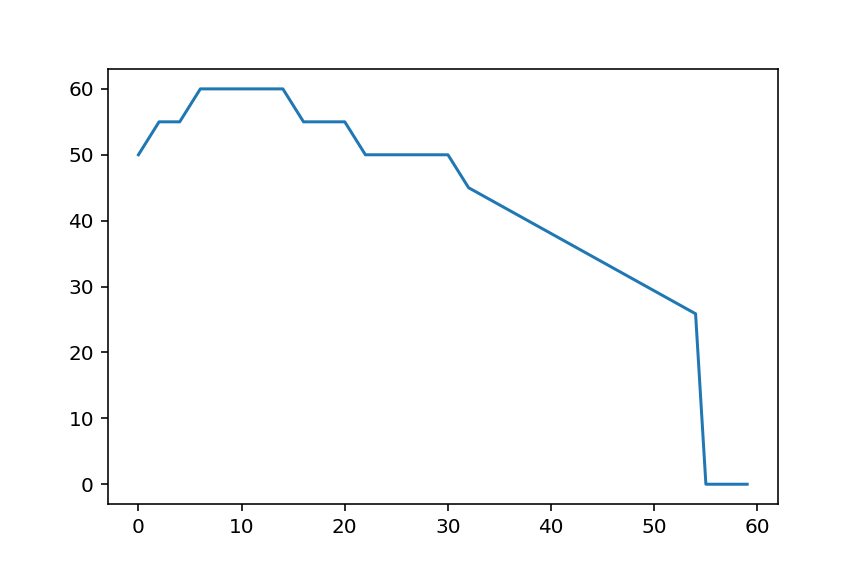

In [115]:
#one important remark: if the number of available timesteps is smaller than a threshold I pad with 0 the end.
#same with the vision data
plt.plot(y[15,:,3])
plt.show()

In [33]:
s = vision_data.shape
print(s)
#s[0] is the storm
#s[1] is the number of timesteps
#s[2] is the value field (geopotential, windspeed u, windspeed v)
#s[3] is the altitude 700, 500, 250
#s[4,5] is the actual map at this timestep, value, and altitude. 1 pixel is 1 degree of latitute and longitude
print("We have {} storms with {} timesteps.".format(s[0], s[1]))

(83, 60, 3, 3, 25, 25)
We have 83 storms with 60 timesteps.


In [39]:
for i in range(vision_data.shape[0]):
    image = torch.tensor(vision_data[i][1])
    print("{}: Number of zeros vs number of total elements: {} vs {}".format(i, torch.sum(image==0), image.numel()))

0: Number of zeros vs number of total elements: 0 vs 5625
1: Number of zeros vs number of total elements: 0 vs 5625
2: Number of zeros vs number of total elements: 0 vs 5625
3: Number of zeros vs number of total elements: 0 vs 5625
4: Number of zeros vs number of total elements: 0 vs 5625
5: Number of zeros vs number of total elements: 0 vs 5625
6: Number of zeros vs number of total elements: 0 vs 5625
7: Number of zeros vs number of total elements: 0 vs 5625
8: Number of zeros vs number of total elements: 0 vs 5625
9: Number of zeros vs number of total elements: 0 vs 5625
10: Number of zeros vs number of total elements: 0 vs 5625
11: Number of zeros vs number of total elements: 0 vs 5625
12: Number of zeros vs number of total elements: 0 vs 5625
13: Number of zeros vs number of total elements: 0 vs 5625
14: Number of zeros vs number of total elements: 0 vs 5625
15: Number of zeros vs number of total elements: 0 vs 5625
16: Number of zeros vs number of total elements: 0 vs 5625
17: Num

In [283]:
%matplotlib notebook 

<IPython.core.display.Javascript object>


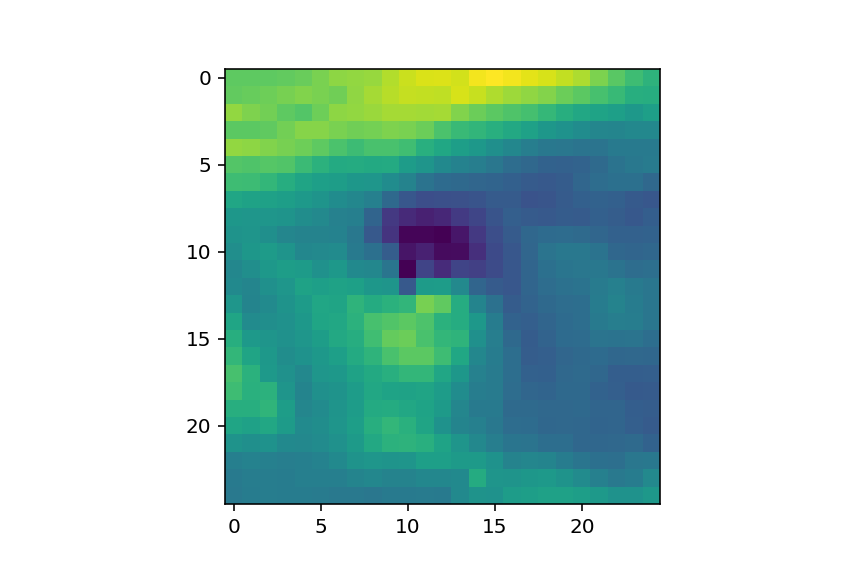

In [295]:
#ani = animate_ouragan(vision_data, 10)
import imp
from utils import plot
imp.reload(plot)
plot.animate_ouragan(vision_data, n=12)

In [120]:
vision_data[0].shape

(60, 3, 3, 25, 25)

## Visualize one map

<IPython.core.display.Javascript object>


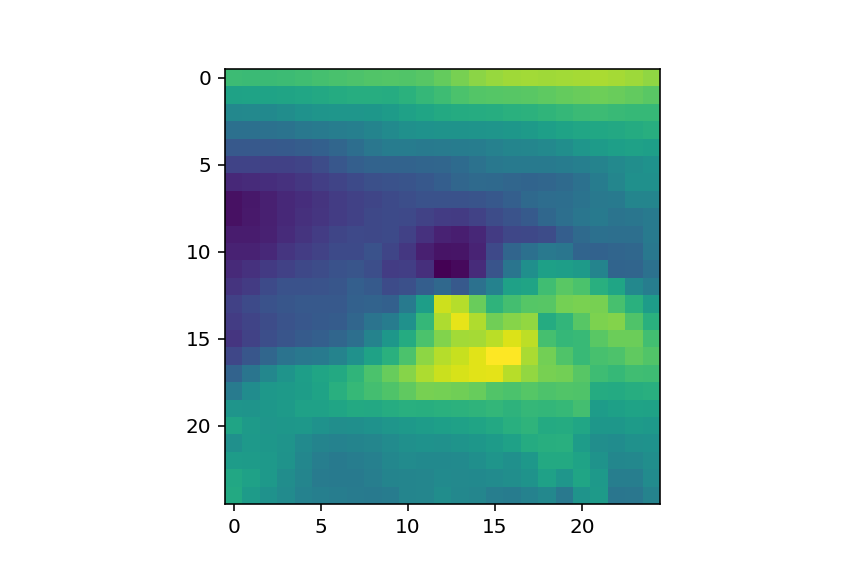

In [122]:
a = vision_data[0, 30, 0, 1]
plt.imshow(a)
plt.show()

In [287]:
#Create Dataset to define a loader with it that will make our lives easier.
from utils import run 
train_data = run.HurricaneDS(vision_data, y)
loader = data.DataLoader(train_data, batch_size=10, shuffle=True)
data_ = next(iter(loader))

Number of elements: 83. Timesteps: 60.        Respective shapes: torch.Size([83, 60, 7]) and torch.Size([83, 60, 3, 3, 25, 25])


In [288]:
for key, value in data_.items():
    print(key, value.size())

X_vision torch.Size([10, 57, 3, 3, 25, 25])
X_stat torch.Size([10, 57, 7])
target_displacement torch.Size([10, 57, 2])
target_velocity torch.Size([10, 57])


# CNN Encoder

## Test

In [31]:
#To test the model I take one storm and the first timestep.
test = torch.Tensor(vision_data[0,0]).reshape(1, 9, 25, 25)
e_d = EncoderDecoder(128, 128)
e_d.eval()
#Here the model outputs the displacement in x and y respective to the last timestep
e_d(test)

tensor([[[ 0.4193, -0.4846]]], grad_fn=<AddBackward0>)

## ConvLSTM cell

In [38]:
c = ConvLSTM(input_dim = 9, hidden_dim=128, kernel_size=(3,3), num_layers=1, batch_first=True, bias = True)

In [39]:
s = vision_data.shape
v = vision_data.reshape(s[0], s[1], s[2]*s[3], s[4], s[5])
v = torch.Tensor(v)

In [40]:
c.eval()
outputs, last_states = c(v[0][:10].unsqueeze(0))

In [41]:
outputs[0][0].shape

torch.Size([10, 128, 25, 25])